**기후 변화에 따른 쌀 생산량 분석 및 예측**<br>
(3-A)202244035 <br>이승예

In [ ]:
# 단계 1: 폰트 설치
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null

fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [ ]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설치

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Optional, Dict, Tuple
from pathlib import Path
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

class DataProcessor:
    """쌀 생산량과 기후 데이터를 처리하는 클래스

    주요 기능:
    1. 쌀 생산량 데이터 전처리 및 구조화
    2. 기후 데이터(연간/월간) 전처리 및 정규화
    3. 결측치 처리 및 데이터 보간
    4. 지역별 데이터 매핑 및 필터링

    주요 처리 과정:
    1. Excel/CSV 파일에서 데이터 로드
    2. 결측치 처리 및 데이터 정규화
    3. 지역별 데이터 매핑 및 통계 계산
    4. 처리된 데이터를 파일로 저장
    """

    # 소수점 정밀도 설정 (모든 수치형 데이터는 소수점 첫째자리까지 표현)
    DECIMAL_PRECISION = 1


    # 모든 기후 관련 처리에서 일관되게 사용되는 지표들
    CLIMATE_METRICS = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']


    # 원본 기후 데이터의 컬럼명을 일관된 형식으로 변환하기 위한 딕셔너리
    # 연간('annual')과 월간('monthly') 데이터의 컬럼명이 서로 다르므로 통일된 형식으로 변환
    CLIMATE_COLUMNS = {
        'annual': {
            '평균기온(°C)합계': '평균기온(°C)',
            '강수량(mm)': '합계 강수량(mm)',
            '평균 상대습도(%)합계': '평균 상대습도(%)',
            '일조시간(hr)': '합계 일조시간(hr)'
        },
        'monthly': {
            '평균기온(°C)': '평균기온(°C)',
            '평균상대습도(%)': '평균 상대습도(%)',
            '월합강수량(00~24h만)(mm)': '합계 강수량(mm)',
            '합계 일조시간(hr)': '합계 일조시간(hr)'
        }
    }

    # 지역별 행정구역 매핑
    # 지점명을 광역시도 단위로 그룹화하기 위한 딕셔너리
    # 키: 지점명, 값: 해당 지점이 속한 광역시도
    REGION_MAPPING = {
        # 전라남도 지역
        '목포': '전라남도', '여수': '전라남도', '순천': '전라남도',
        '완도': '전라남도', '진도(첨찰산)': '전라남도', '진도군': '전라남도',
        '해남': '전라남도', '고흥': '전라남도', '광양시': '전라남도',
        '보성군': '전라남도', '강진군': '전라남도', '장흥': '전라남도',

        # 충청남도 지역
        '서산': '충청남도', '천안': '충청남도', '보령': '충청남도',
        '부여': '충청남도', '홍성': '충청남도',

        # 전라북도 지역
        '전주': '전라북도', '군산': '전라북도', '부안': '전라북도',
        '임실': '전라북도', '정읍': '전라북도', '남원': '전라북도',
        '장수': '전라북도', '고창군': '전라북도', '순창군': '전라북도',

        # 경상북도 지역
        '포항': '경상북도', '안동': '경상북도', '상주': '경상북도',
        '울진': '경상북도', '봉화': '경상북도', '영주': '경상북도',
        '문경': '경상북도', '청송군': '경상북도', '영덕': '경상북도',
        '의성': '경상북도', '구미': '경상북도', '영천': '경상북도',
        '경주시': '경상북도'
    }

    def __init__(self, target_regions: List[str]):
        self.target_regions = target_regions

    def _calculate_location_means(self, df: pd.DataFrame,group_by: str, columns: List[str], is_monthly: bool = False) -> Dict:
        """
        지역별 평균값 계산

        Notes:
        - 월별 데이터의 경우 각 월별로 개별 평균 계산
        - 특정 월의 데이터가 없는 경우 전체 평균으로 대체
        """
        if is_monthly:
            means = {}
            for col in columns:
                if col in df.columns:
                    monthly_means = {}
                    for month in range(1, 13):
                        month_data = df[df['일시'].str.endswith(f'-{month:02d}')][col]
                        monthly_means[month] = (
                            month_data.mean() if not month_data.empty
                            else df[col].mean()
                        )
                    means[col] = monthly_means
            return means
        else:
            return {
                col: df[col].mean()
                for col in columns
                if col in df.columns
            }

    def _sort_dataframe(self, df: pd.DataFrame, location_col: str) -> pd.DataFrame:
        """데이터프레임 정렬을 위한 통일된 메서드"""
        return df.sort_values([location_col, '일시']).reset_index(drop=True)

    def fill_missing_years(self, df: pd.DataFrame, start_year: int = 2008,
                          end_year: int = 2023) -> pd.DataFrame:
        """
        2008-2023년 범위의 누락된 연도 데이터를 보간하는 함수

        Args:
            df (pd.DataFrame): 처리할 데이터프레임
            start_year (int): 시작 연도 (기본값: 2008)
            end_year (int): 종료 연도 (기본값: 2023)

        Returns:
            pd.DataFrame: 결측치가 보간된 데이터프레임

        처리 과정:
        1. 각 지역별로 누락된 연도/월 확인
        2. 해당 지역의 평균값으로 결측치 대체
        3. 월별 데이터의 경우 동일 월의 평균값으로 대체 (계절성 고려)
        4. 데이터의 일관성을 위해 소수점 첫째자리까지 표준화

        Notes:
            - 월별 데이터의 경우 YYYY-MM 형식으로 처리
            - 연간 데이터의 경우 YYYY 형식으로 처리
            - 결측치는 해당 지역의 평균값으로 대체
        """
        result_df = []
        is_monthly = isinstance(df['일시'].iloc[0], str) and '-' in str(df['일시'].iloc[0])

        for location in df['지점명'].unique():  # 각 지역별로 반복
            location_data = df[df['지점명'] == location].copy()
            location_code = location_data['지점'].iloc[0]

            if is_monthly: # 월별 데이터 처리
                existing_dates = location_data['일시'].unique()
                all_dates = [
                    f"{year}-{month:02d}"
                    for year in range(start_year, end_year + 1)
                    for month in range(1, 13)
                ]

                location_means = self._calculate_location_means( # 지역별 월별 평균 계산
                    location_data, '지점명', self.CLIMATE_METRICS, is_monthly=True
                )

                missing_dates = [date for date in all_dates if date not in existing_dates] # 누락된 날짜 식별
                for date in missing_dates:
                    year, month = map(int, date.split('-')) # 년월 분리
                    new_row = { # 새로운 행 생성
                        '지점': location_code,
                        '지점명': location,
                        '일시': date,
                        **{col: location_means[col][month] # 월별 평균값으로 채움
                           for col in self.CLIMATE_METRICS
                           if col in location_data.columns}
                    }
                    result_df.append(new_row)
            else:  # 연간 데이터 처리
                existing_years = location_data['일시'].astype(int).unique()
                all_years = list(range(start_year, end_year + 1))

                location_means = self._calculate_location_means( # 지역별 평균 계산
                    location_data, '지점명', self.CLIMATE_METRICS
                )

                missing_years = [year for year in all_years if year not in existing_years] # 누락 연도 식별
                for year in missing_years:
                    new_row = { # 새로운 행 생성
                        '지점': location_code,
                        '지점명': location,
                        '일시': year,
                        **location_means # 평균값으로 채움
                    }
                    result_df.append(new_row)

            result_df.extend(location_data.to_dict('records'))

        result_df = pd.DataFrame(result_df)
        result_df['지점'] = result_df['지점'].astype(int)

        result_df = self._sort_dataframe(result_df, '지점명')
        for col in self.CLIMATE_METRICS:
            if col in result_df.columns:
                result_df[col] = result_df[col].round(self.DECIMAL_PRECISION)

        return result_df

    def process_rice_data(self, file_path: Path, output_path: Optional[Path] = None) -> pd.DataFrame:
        """
        쌀 생산량 데이터를 처리하는 메인 함수

        처리 과정:
        1. Excel 파일에서 데이터 로드
        2. 연도별 재배면적과 생산량 데이터 추출
        3. 데이터 재구조화 (Long format으로 변환)
        4. 대상 지역 필터링 및 정렬
        """
        try:
            raw_data = pd.read_excel(file_path)
        except Exception as e:
            raise ValueError(f"Excel 파일 읽기 실패: {str(e)}")

        # 연도 컬럼 추출 (숫자로 된 컬럼명만 선택)
        years = [int(col) for col in raw_data.columns[1:] if str(col).isdigit()]
        unique_years = sorted(set(years))

        # 데이터 재구조화
        restructured_data = []
        for idx, row in raw_data.iloc[2:].iterrows():
            region_name = row.iloc[0]
            for i, year in enumerate(unique_years):
                # 각 연도별로 재배면적과 생산량이 2개 컬럼씩 존재
                area_idx = i * 2 + 1   # 재배면적 컬럼 인덱스
                prod_idx = i * 2 + 2   # 생산량 컬럼 인덱스

                try:
                    restructured_data.append({
                        '행정구역': region_name,
                        '일시': year,
                        '재배면적(ha)': row.iloc[area_idx],
                        '생산량(톤)': row.iloc[prod_idx]
                    })
                except (ValueError, IndexError):
                    continue

        # 대상 지역 필터링 및 정렬
        processed_df = pd.DataFrame(restructured_data)
        processed_df = self._filter_and_sort_data(processed_df)

        if output_path:
            processed_df.to_excel(output_path, index=False)

        return processed_df

    def process_climate_data(
        self,
        annual_path: Path,
        monthly_path: Path
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        연간/월간 기후 데이터를 처리하는 메인 함수

        처리 과정:
        1. CSV 파일에서 데이터 로드 (EUC-KR 인코딩)
        2. 결측 연도/월 데이터 보간
        3. 컬럼명 통일 및 행정구역 정보 추가
        4. 결측치 처리 (지역별 평균으로 대체)

        Notes:
            - 연간/월간 데이터는 서로 다른 컬럼명 사용
            - CLIMATE_COLUMNS 매핑을 통해 컬럼명 통일
            - 모든 수치는 소수점 첫째자리까지 표현
        """
        annual_climate = pd.read_csv(annual_path, encoding='euc-kr')
        monthly_climate = pd.read_csv(monthly_path, encoding='euc-kr')

        annual_climate = self.fill_missing_years(annual_climate)
        monthly_climate = self.fill_missing_years(monthly_climate)

        annual_climate = self._prepare_climate_data(annual_climate, 'annual')
        monthly_climate = self._prepare_climate_data(monthly_climate, 'monthly')

        annual_climate = self.fill_missing_climate_data(annual_climate)
        monthly_climate = self.fill_missing_climate_data(monthly_climate)

        return annual_climate, monthly_climate

    def _filter_and_sort_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        데이터프레임을 필터링하고 정렬하는 헬퍼 메서드

        Notes:
            - target_regions에 포함된 지역만 필터링
            - 행정구역과 시간순으로 정렬
        """
        if self.target_regions:
            df = df[df['행정구역'].isin(self.target_regions)]
        return self._sort_dataframe(df, '행정구역')

    def _prepare_climate_data(self, df: pd.DataFrame, data_type: str) -> pd.DataFrame:
        """
        기후 데이터 전처리를 위한 헬퍼 메서드

        처리 과정:
        1. 컬럼명을 통일된 형식으로 변경
        2. 지점명을 행정구역으로 매핑
        3. 대상 지역만 필터링

        Notes:
            - CLIMATE_COLUMNS 딕셔너리를 통해 컬럼명 변환
            - REGION_MAPPING 딕셔너리를 통해 지역 매핑
        """
        df = df.rename(columns=self.CLIMATE_COLUMNS[data_type])
        df['행정구역'] = df['지점명'].map(self.REGION_MAPPING)
        return df[df['행정구역'].isin(self.target_regions)]

    def fill_missing_climate_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        기후 데이터의 결측치를 처리하는 헬퍼 메서드

        처리 과정:
        1. 빈 문자열을 NaN으로 변환
        2. 숫자형으로 변환 불가능한 값을 NaN으로 처리
        3. 각 지역별 평균값으로 NaN 대체
        4. 소수점 첫째자리까지 반올림

        Notes:
            - CLIMATE_METRICS에 정의된 컬럼만 처리
            - 지역별로 평균을 계산하여 결측치 대체
            - 모든 수치를 DECIMAL_PRECISION 자리까지 반올림
        """
        df_filled = df.copy()

        for col in self.CLIMATE_METRICS:
            if col in df.columns:
                df_filled[col] = pd.to_numeric(
                    df_filled[col].replace('', np.nan),
                    errors='coerce'
                )
                region_means = (df_filled.groupby('행정구역')[col]
                              .transform('mean')
                              .round(self.DECIMAL_PRECISION))
                df_filled[col] = (df_filled[col]
                                .fillna(region_means)
                                .round(self.DECIMAL_PRECISION))
        return df_filled


def main():
    """메인 실행 함수"""
    # 파일 경로 설정
    rice_file = Path('/content/전국_시군별_논벼_생산량.xlsx')
    annual_climate_file = Path('/content/연간기후전체지역.csv')
    monthly_climate_file = Path('/content/월별기후전체지역.csv')

    # 타겟 지역 설정
    target_regions = ['전라남도', '충청남도', '전라북도', '경상북도']

    # 데이터 프로세서 인스턴스 생성
    processor = DataProcessor(target_regions)

    try:
        # 1. 쌀 생산량 데이터 처리
        rice_data = processor.process_rice_data(
            rice_file,
            Path('filtered_rice_production.xlsx')
        )

        # 2. 기후 데이터 처리
        annual_climate, monthly_climate = processor.process_climate_data(
            annual_climate_file,
            monthly_climate_file
        )

        # 3. 처리된 기후 데이터 저장
        annual_climate.to_csv('filtered_climate_annual_data.csv',
                            index=False, encoding='utf-8-sig')
        monthly_climate.to_csv('filtered_climate_monthly_data.csv',
                             index=False, encoding='utf-8-sig')

        print("모든 데이터 처리가 완료되었습니다.")

    except Exception as e:
        print(f"처리 중 오류가 발생했습니다: {str(e)}")

if __name__ == "__main__":
    main()

모든 데이터 처리가 완료되었습니다.


In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class RiceProductionAnalyzer:
    """쌀 생산량 분석을 위한 클래스"""

    def __init__(self):
        """데이터 로드 및 초기화"""
        print("\n🌾 쌀 생산량 분석 시스템을 초기화합니다...")
        self.rice_data = pd.read_excel('/content/filtered_rice_production.xlsx')
        self.climate_annual = pd.read_csv('/content/filtered_climate_annual_data.csv')
        self.climate_monthly = pd.read_csv('/content/filtered_climate_monthly_data.csv')
        self.processed_data = None
        self.region_colors = {
            '전라남도': '#1f77b4',  # 파란색
            '충청남도': '#2ca02c',  # 초록색
            '전라북도': '#ff7f0e',  # 주황색
            '경상북도': '#d62728'   # 빨간색
        }
        print("✅ 데이터 로드 완료\n")
        self.prepare_data()

    def prepare_data(self):
        """데이터 전처리"""
        # 날짜 형식 통일
        self._unify_date_formats()
        # 월별 기후 데이터 피봇 및 병합
        monthly_pivot = self._create_monthly_pivot()
        # 최종 데이터 병합
        self._merge_all_data(monthly_pivot)

    def _unify_date_formats(self):
        """날짜 형식 통일화"""
        self.climate_annual['일시'] = self.climate_annual['일시'].astype(int)
        self.climate_monthly['연도'] = self.climate_monthly['일시'].str.split('-').str[0].astype(int)
        self.climate_monthly['월'] = self.climate_monthly['일시'].str.split('-').str[1].astype(int)

    def _create_monthly_pivot(self):
        """월별 기후 데이터 피봇 테이블 생성"""
        pivot = self.climate_monthly.pivot_table(
            index=['행정구역', '연도'],
            columns='월',
            values=['평균기온(°C)', '평균 상대습도(%)', '합계 강수량(mm)', '합계 일조시간(hr)']
        ).reset_index()

        # 컬럼명 재구성
        pivot.columns = [f"{col[0]}_{col[1]}월" if isinstance(col, tuple) and col[1] != ""
                        else col[0] for col in pivot.columns]
        return pivot.rename(columns={'연도': '일시'})

    def _merge_all_data(self, monthly_pivot):
        """모든 데이터 병합"""
        merged_data = pd.merge(
            self.rice_data,
            self.climate_annual[['행정구역', '일시', '평균기온(°C)', '합계 강수량(mm)',
                               '평균 상대습도(%)', '합계 일조시간(hr)']],
            on=['행정구역', '일시']
        )
        self.processed_data = pd.merge(merged_data, monthly_pivot, on=['행정구역', '일시'])

    def analyze_production_changes(self):
        """생산량 변화율 분석 및 시각화"""
        # 기준년도(2008) 대비 변화율 계산
        self.rice_data['단위면적당생산량'] = (self.rice_data['생산량(톤)'] /
                                            self.rice_data['재배면적(ha)']).round(2)
        pivot_data = self.rice_data.pivot(index='일시', columns='행정구역', values='단위면적당생산량')
        change_ratio = (pivot_data / pivot_data.iloc[0] * 100 - 100).reset_index()
        base_production = pivot_data.iloc[0].round(2)

        # 데이터 재구성
        change_ratio_long = pd.melt(change_ratio,
                                  id_vars=['일시'],
                                  var_name='행정구역',
                                  value_name='변화율')

        # 범례 텍스트 생성
        custom_legend = {region: f"{region} (2008년: {base_production[region]:,.2f}톤/ha)"
                        for region in pivot_data.columns}

        return self._create_production_change_plot(change_ratio_long, custom_legend)

    def _create_production_change_plot(self, data, custom_legend):
        """생산량 변화 그래프 생성"""
        fig = px.line(data,
                     x='일시',
                     y='변화율',
                     color='행정구역',
                     title='2008년 대비 지역별 쌀 생산량 변화율 (%)',
                     labels={'변화율': '변화율 (%)', '일시': '연도'},
                     markers=True,
                     color_discrete_map=self.region_colors)

        # 그래프 스타일 설정
        for trace in fig.data:
            trace.name = custom_legend[trace.name]
            trace.line.width = 3
            trace.marker.size = 8

        fig.update_layout(
            height=600,
            width=1000,
            yaxis_tickformat='.1f',
            legend_title_text='지역 (2008년 기준 생산량)',
            template='plotly_white',
            font=dict(family='Noto Sans KR', size=12),
            title=dict(font=dict(size=20, color='black'), x=0.5, y=0.95),
            legend=dict(yanchor="top", y=0.99, xanchor="right", x=0.99,
                       bgcolor='rgba(255, 255, 255, 0.8)'),
            plot_bgcolor='white',
            paper_bgcolor='white',
            xaxis=self._get_axis_style(),
            yaxis=self._get_axis_style()
        )
        return fig

    def _get_axis_style(self):
        """축 스타일 설정"""
        return dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray',
            title_font=dict(size=14),
            tickfont=dict(size=12)
        )

    def analyze_regional_comparison(self):
        """지역별 생산 특성 비교 분석"""
        stats_df = self._calculate_regional_stats()
        return self._create_regional_comparison_plot(stats_df)

    def _calculate_regional_stats(self):
        """지역별 통계 계산"""
        stats_df = self.rice_data.groupby(['행정구역', '일시']).agg({
            '재배면적(ha)': 'sum',
            '생산량(톤)': 'sum'
        }).reset_index()
        stats_df['단위면적당생산량'] = (stats_df['생산량(톤)'] /
                                      stats_df['재배면적(ha)']).round(2)
        return stats_df

    def _create_regional_comparison_plot(self, stats_df):
        """지역별 비교 그래프 생성"""
        fig = make_subplots(
            rows=1, cols=3,
            subplot_titles=('지역별 재배면적 (ha)',
                          '지역별 총 생산량 (톤)',
                          '지역별 단위면적당 생산량 (톤/ha)')
        )

        measures = ['재배면적(ha)', '생산량(톤)', '단위면적당생산량']
        for i, measure in enumerate(measures, 1):
            for region in stats_df['행정구역'].unique():
                region_data = stats_df[stats_df['행정구역'] == region]
                fig.add_trace(
                    go.Box(
                        y=region_data[measure],
                        name=region,
                        boxpoints='all',
                        pointpos=0,
                        marker_color=self.region_colors[region],
                        line_color=self.region_colors[region],
                        showlegend=(i == 1)
                    ),
                    row=1, col=i
                )

        fig.update_layout(
            height=600,
            width=1500,
            title_text="지역별 쌀 생산 특성 비교 (2008-2023)",
            showlegend=True
        )

        for i, measure in enumerate(measures, 1):
            fig.update_yaxes(title_text=measure, row=1, col=i)

        return fig

    def analyze_climate_vulnerability(self):
        """지역별 기후 취약성 분석"""
        climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']
        vulnerability_metrics = {}

        for region in self.processed_data['행정구역'].unique():
            region_data = self.processed_data[self.processed_data['행정구역'] == region]

            # 각 기후 변수의 변동계수(CV) 계산
            cv_metrics = {}
            for var in climate_vars:
                cv = region_data[var].std() / region_data[var].mean()
                cv_metrics[f'{var}_CV'] = cv

            # 생산량 변동성
            unit_production = region_data['생산량(톤)'] / region_data['재배면적(ha)']
            production_cv = unit_production.std() / unit_production.mean()
            cv_metrics['단위면적당생산량_CV'] = production_cv  # 이름도 함께 변경

            vulnerability_metrics[region] = cv_metrics

        vulnerability_df = pd.DataFrame(vulnerability_metrics).T

        # Plotly 히트맵 생성
        fig = go.Figure(data=go.Heatmap(
            z=vulnerability_df.values,
            x=vulnerability_df.columns,
            y=vulnerability_df.index,
            text=np.round(vulnerability_df.values, 3),
            texttemplate='%{text}',
            textfont={"size": 10},
            hoverongaps=False,
            colorscale='YlOrRd',
            colorbar=dict(title='변동계수(CV)'),
        ))

        fig.update_layout(
            title='지역별 기후 취약성 지표 (변동계수 기반)',
            xaxis_title='기후 변수',
            yaxis_title='지역',
            width=1000,
            height=600,
        )

        return fig, vulnerability_df

    def analyze_optimal_conditions(self):
        """지역별 최적 재배 조건 분석"""
        climate_vars = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']
        optimal_conditions = {}

        for region in self.processed_data['행정구역'].unique():
            # 각 지역별로 상위 20% 데이터 추출
            region_data = self.processed_data[self.processed_data['행정구역'] == region]
            threshold = region_data['생산량(톤)'].quantile(0.8)
            region_optimal = region_data[region_data['생산량(톤)'] >= threshold]

            conditions = {}
            for var in climate_vars:
                conditions[f'{var}_범위'] = {
                    '최소': region_optimal[var].min(),
                    '최대': region_optimal[var].max(),
                    '평균': region_optimal[var].mean()
                }

            optimal_conditions[region] = conditions

        fig = make_subplots(
            rows=1,
            cols=4,
            subplot_titles=[f'{var}' for var in climate_vars],
            horizontal_spacing=0.08
        )

        for idx, var in enumerate(climate_vars, 1):
            regions = []
            means = []
            mins = []
            maxs = []
            colors = []

            for region in optimal_conditions.keys():
                regions.append(region)
                means.append(optimal_conditions[region][f'{var}_범위']['평균'])
                mins.append(optimal_conditions[region][f'{var}_범위']['최소'])
                maxs.append(optimal_conditions[region][f'{var}_범위']['최대'])
                colors.append(self.region_colors[region])

            fig.add_trace(
                go.Bar(
                    name=var,
                    y=regions,
                    x=means,
                    error_x=dict(
                        type='data',
                        symmetric=False,
                        array=[max-mean for max, mean in zip(maxs, means)],
                        arrayminus=[mean-min for min, mean in zip(mins, means)],
                        color='rgba(0,0,0,0.2)',
                        thickness=1.5,
                        width=10
                    ),
                    text=[f'{mean:.1f}' for mean in means],
                    textposition='auto',
                    marker=dict(
                        color=colors,
                        line=dict(width=1, color='#ffffff')
                    ),
                    showlegend=False,
                    orientation='h',
                    hovertemplate='%{y}' +
                                f'{var}: ' + '%{x:.1f}' +
                                '최소: %{customdata[0]:.1f}' +
                                '최대: %{customdata[1]:.1f}' +
                                '',
                    customdata=list(zip(mins, maxs))
                ),
                row=1,
                col=idx
            )

            fig.update_xaxes(
                title=dict(
                    text=var,
                    font=dict(size=12, color='#2c3e50')
                ),
                tickfont=dict(size=10),
                showgrid=True,
                gridwidth=1,
                gridcolor='rgba(189, 195, 199, 0.4)',
                row=1,
                col=idx
            )

            fig.update_yaxes(
                tickfont=dict(size=12, color='#2c3e50'),
                showgrid=False,
                row=1,
                col=idx
            )

        fig.update_layout(
            height=350,
            width=1500,
            title=dict(
                text='지역별 최적 기후 조건 분석 (상위 20% 생산량 기준)',
                x=0.5,
                font=dict(size=20, color='#2c3e50', family='Noto Sans KR')
            ),
            showlegend=False,
            template='plotly_white',
            font=dict(family='Noto Sans KR'),
            plot_bgcolor='white',
            paper_bgcolor='white',
            margin=dict(t=100, b=50, l=50, r=50),
            bargap=0.2,
        )

        for i in fig['layout']['annotations']:
            i['font'] = dict(size=14, color='#2c3e50', family='Noto Sans KR')

        return fig, optimal_conditions

    def run_all_analyses(self):
        """모든 분석 실행"""
        print("1️⃣ 생산량 변화 분석")
        print("   📈 2008년 대비 지역별 쌀 생산량 변화율을 분석중...")
        fig_changes = self.analyze_production_changes()
        fig_changes.show()

        print("2️⃣ 지역별 생산 특성 비교")
        print("   📊 재배면적, 생산량, 단위면적당 생산량을 분석중...")
        fig_comparison = self.analyze_regional_comparison()
        fig_comparison.show()

        print("3️⃣ 기후 취약성 분석")
        print("   🌡️ 기후 변수별 지역 취약성을 평가중...")
        fig_vulnerability, vulnerability_df = self.analyze_climate_vulnerability()
        fig_vulnerability.show()

        print("4️⃣ 최적 재배 조건 분석")
        print("   🎯 지역별 최적 기후 조건을 도출중...")
        fig_optimal, optimal_conditions = self.analyze_optimal_conditions()
        fig_optimal.show()

        print("="*50)
        print("🎉 모든 분석이 성공적으로 완료되었습니다!")
        print("="*50 + "\n")

def main():
    """메인 함수"""
    print("\n🚀 쌀 생산량 종합 분석 시스템을 시작합니다...")
    analyzer = RiceProductionAnalyzer()
    analyzer.run_all_analyses()

if __name__ == "__main__":
    main()


🚀 쌀 생산량 종합 분석 시스템을 시작합니다...

🌾 쌀 생산량 분석 시스템을 초기화합니다...
✅ 데이터 로드 완료

1️⃣ 생산량 변화 분석
   📈 2008년 대비 지역별 쌀 생산량 변화율을 분석중...


2️⃣ 지역별 생산 특성 비교
   📊 재배면적, 생산량, 단위면적당 생산량을 분석중...


3️⃣ 기후 취약성 분석
   🌡️ 기후 변수별 지역 취약성을 평가중...


4️⃣ 최적 재배 조건 분석
   🎯 지역별 최적 기후 조건을 도출중...


🎉 모든 분석이 성공적으로 완료되었습니다!




                    🌾 쌀 생산량 예측 시스템 🌾

📊 [2023년 쌀 생산량 예측 분석]
----------------------------------------------------------------------

📍 지역별 예측 결과 분석
----------------------------------------------------------------------
※ 단위: 톤
    행정구역   실제_생산량   예측_생산량           오차    오차율(%)
15  경상북도  501,248  508,569   7320.96875  1.460548
31  전라남도  736,694  772,100  35406.50000  4.806134
47  전라북도  582,477  570,607 -11870.37500 -2.037913
63  충청남도  726,989  680,809 -46180.12500 -6.352245

📈 모델 성능 평가 지표:
----------------------------------------------------------------------
         RMSE         MAE      R2  Adjusted_R2    MAPE  Mean_Error  \
0  29919.5863  25194.4922  0.9092       1.0049  3.6642   3830.7578   

    Std_Error  Confidence_Interval  Error_Normality_p_value  Sample_Size  
0  29673.3372           29079.8704                      1.0            4  

🔍 예측 정확도 검증:
----------------------------------------------------------------------
신뢰성 검정 P-값: 1.0000
✅ 예측 결과가 통계적으로 신뢰할 수 있는 수준입니다.

🔮 미래 생산량 

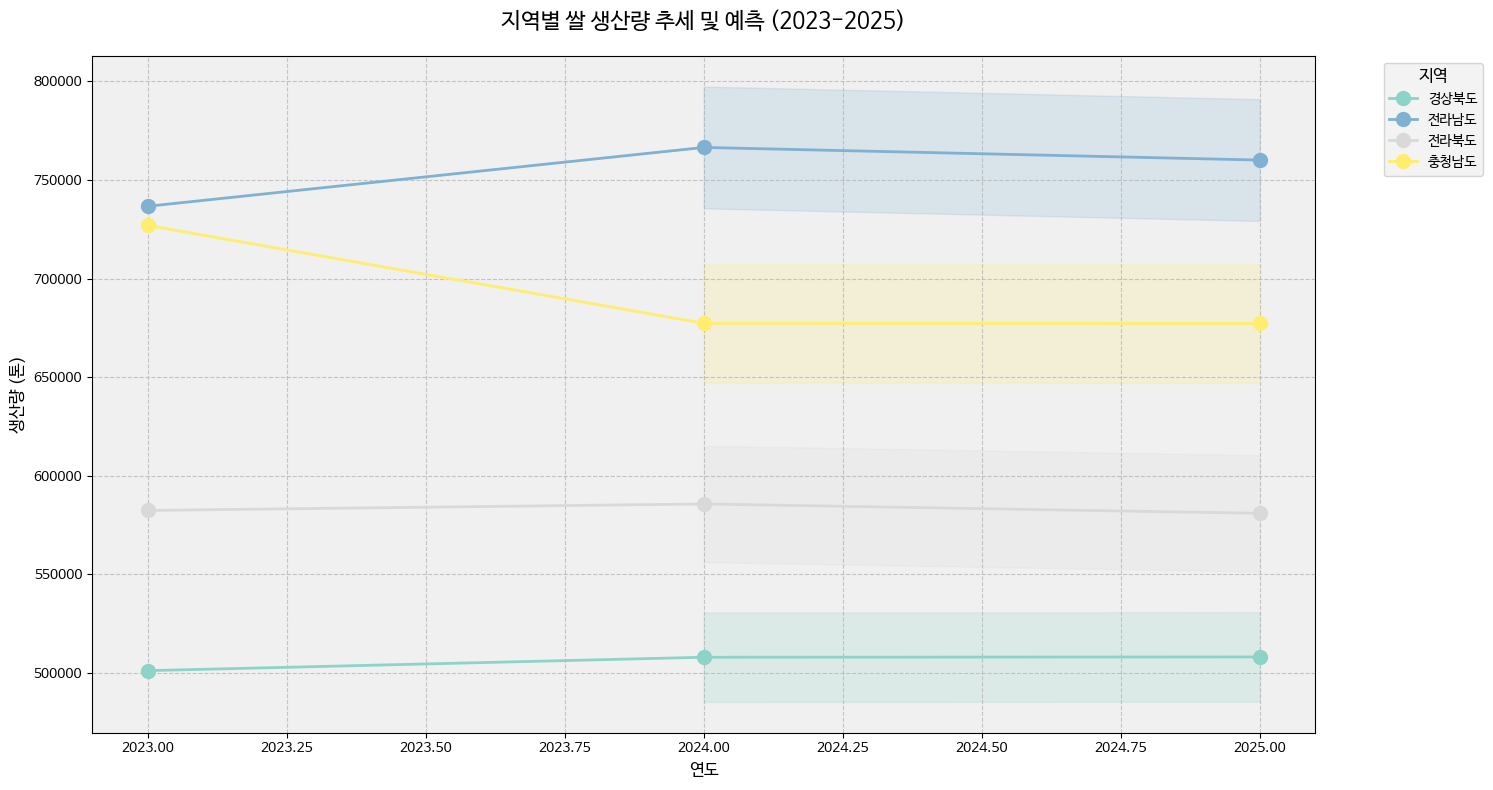


📊 2024년, 2025년 예측 결과
----------------------------------------------------------------------

▶ 경상북도
   2023년 실제 생산량: 501,248 톤
   2024년 예측 생산량: 508,046 톤
   2025년 예측 생산량: 508,200 톤
   2024-2025 변화율: 0.03%

▶ 전라남도
   2023년 실제 생산량: 736,694 톤
   2024년 예측 생산량: 766,530 톤
   2025년 예측 생산량: 760,122 톤
   2024-2025 변화율: -0.84%

▶ 전라북도
   2023년 실제 생산량: 582,477 톤
   2024년 예측 생산량: 585,759 톤
   2025년 예측 생산량: 581,020 톤
   2024-2025 변화율: -0.81%

▶ 충청남도
   2023년 실제 생산량: 726,989 톤
   2024년 예측 생산량: 677,366 톤
   2025년 예측 생산량: 677,284 톤
   2024-2025 변화율: -0.01%


In [50]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import matplotlib.pyplot as plt

class RiceProductionPredictor:
    def __init__(self):
        """데이터 로드 및 초기화"""
        try:
            self.rice_data = pd.read_excel('/content/filtered_rice_production.xlsx')
            self.climate_annual = pd.read_csv('/content/filtered_climate_annual_data.csv')
            self.climate_monthly = pd.read_csv('/content/filtered_climate_monthly_data.csv')
            self.processed_data = None
            self.model = None
            self.scaler = StandardScaler()
            self.feature_columns = None
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {str(e)}")
            raise

    def prepare_data(self):
        """데이터 전처리"""
        try:
            # 연간 기후 데이터 처리
            climate_annual_mean = self.climate_annual.groupby(['행정구역', '일시']).agg({
                '평균기온(°C)': 'mean',
                '합계 강수량(mm)': 'sum',
                '평균 상대습도(%)': 'mean',
                '합계 일조시간(hr)': 'mean'
            }).reset_index()

            # 월별 기후 데이터 처리
            self.climate_monthly['연도'] = self.climate_monthly['일시'].str.split('-').str[0].astype(int)
            self.climate_monthly['월'] = self.climate_monthly['일시'].str.split('-').str[1].astype(int)

            # 피봇 테이블 생성
            pivot_dfs = []
            measures = ['평균기온(°C)', '합계 강수량(mm)', '평균 상대습도(%)', '합계 일조시간(hr)']

            for measure in measures:
                pivot_df = pd.pivot_table(
                    self.climate_monthly,
                    values=measure,
                    index=['행정구역', '연도'],
                    columns='월',
                    aggfunc='mean' if measure in ['평균기온(°C)', '평균 상대습도(%)'] else 'sum'
                ).reset_index()

                pivot_df.columns = [str(col) if isinstance(col, int) else col for col in pivot_df.columns]
                pivot_df.columns = [f"{measure}_{col}월" if col.isdigit() else col for col in pivot_df.columns]
                pivot_dfs.append(pivot_df)

            # 데이터 병합
            climate_monthly_pivot = pivot_dfs[0]
            for df in pivot_dfs[1:]:
                climate_monthly_pivot = pd.merge(
                    climate_monthly_pivot,
                    df,
                    on=['행정구역', '연도'],
                    how='inner'
                )

            climate_monthly_pivot = climate_monthly_pivot.rename(columns={'연도': '일시'})

            merged_data = pd.merge(
                self.rice_data,
                climate_annual_mean,
                on=['행정구역', '일시'],
                how='left'
            )

            self.processed_data = pd.merge(
                merged_data,
                climate_monthly_pivot,
                on=['행정구역', '일시'],
                how='left'
            )

            # 이전 연도 데이터 추가
            self.processed_data['이전년도_생산량'] = self.processed_data.groupby('행정구역')['생산량(톤)'].shift(1)
            self.processed_data['이전년도_재배면적'] = self.processed_data.groupby('행정구역')['재배면적(ha)'].shift(1)

            # 결측치 제거 및 범주형 변수 처리
            self.processed_data = self.processed_data.dropna()
            self.processed_data = pd.get_dummies(self.processed_data, columns=['행정구역'], prefix='지역')

            return self.processed_data

        except Exception as e:
            print(f"데이터 전처리 중 오류 발생: {str(e)}")
            raise

    def train_model(self, target_year=2023):
        """모델 학습"""
        try:
            data = self.prepare_data()

            # 학습 데이터와 테스트 데이터 분리
            train_data = data[data['일시'] < target_year]
            test_data = data[data['일시'] == target_year]

            if len(test_data) == 0:
                raise ValueError(f"{target_year}년 데이터가 없습니다.")

            # 특성과 타겟 분리
            self.feature_columns = [col for col in data.columns if col not in ['생산량(톤)', '일시']]
            X_train = train_data[self.feature_columns]
            y_train = train_data['생산량(톤)']
            X_test = test_data[self.feature_columns]
            y_test = test_data['생산량(톤)']

            # 특성 스케일링
            X_train_scaled = self.scaler.fit_transform(X_train)
            X_test_scaled = self.scaler.transform(X_test)

            # 모델 학습
            self.model = XGBRegressor(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            )
            self.model.fit(X_train_scaled, y_train)

            # 예측 및 평가
            y_pred = self.model.predict(X_test_scaled)

            # 평가 지표 계산
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

            # 원본 지역명 복원
            region_columns = [col for col in test_data.columns if col.startswith('지역_')]
            region_mapping = test_data[region_columns].idxmax(axis=1).map(lambda x: x.replace('지역_', ''))

            # 결과 데이터프레임 생성
            results = pd.DataFrame({
                '행정구역': region_mapping,
                '실제_생산량': y_test,
                '예측_생산량': y_pred,
                '오차': y_pred - y_test,
                '오차율(%)': ((y_pred - y_test) / y_test) * 100
            })

            # 특성 중요도 계산
            feature_importance = pd.DataFrame({
                'feature': self.feature_columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)

            return results, {'RMSE': rmse, 'R2': r2, 'MAPE': mape}, feature_importance

        except Exception as e:
            print(f"모델 학습 중 오류 발생: {str(e)}")
            raise

    def predict_future(self, future_year):
        """미래 생산량 예측"""
        try:
            if not self.model:
                self.train_model()

            region_columns = [col for col in self.processed_data.columns if col.startswith('지역_')]
            regions = [col.replace('지역_', '') for col in region_columns]

            predictions = []

            for region in regions:
                region_mask = self.processed_data[f'지역_{region}'] == 1
                region_data = self.processed_data[region_mask].copy()
                latest_data = region_data.iloc[-1:].copy()
                latest_data['일시'] = future_year

                # 기후 변수 추세 예측
                for col in self.processed_data.columns:
                    if any(var in col for var in ['평균기온', '강수량', '상대습도', '일조시간']):
                        years = region_data['일시'].values
                        values = region_data[col].values
                        trend = np.polyfit(years, values, deg=2)
                        projected_value = np.polyval(trend, future_year)
                        latest_data[col] = projected_value

                # 재배면적 추세 예측
                years = region_data['일시'].values
                areas = region_data['재배면적(ha)'].values
                area_trend = np.polyfit(years, areas, deg=2)
                projected_area = max(0, np.polyval(area_trend, future_year))
                latest_data['재배면적(ha)'] = projected_area

                # 이전 연도 데이터 업데이트
                latest_data['이전년도_생산량'] = region_data.iloc[-1]['생산량(톤)']
                latest_data['이전년도_재배면적'] = region_data.iloc[-1]['재배면적(ha)']

                # 예측
                X_future = latest_data[self.feature_columns]
                X_future_scaled = self.scaler.transform(X_future)
                pred = self.model.predict(X_future_scaled)[0]

                # 신뢰구간 계산
                base_std = np.std(region_data['생산량(톤)']) / np.sqrt(len(region_data))
                confidence_interval = 1.96 * base_std

                predictions.append({
                    '행정구역': region,
                    '예측_생산량': pred,
                    '신뢰구간_하한': max(0, pred - confidence_interval),
                    '신뢰구간_상한': pred + confidence_interval,
                    '재배면적(ha)': latest_data['재배면적(ha)'].iloc[0]
                })

            return pd.DataFrame(predictions)

        except Exception as e:
            print(f"미래 예측 중 오류 발생: {str(e)}")
            raise

    def evaluate_predictions(self, y_true, y_pred):
        """예측 결과에 대한 평가 지표 계산"""
        try:
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

            # Adjusted R2 계산
            n = len(y_true)
            p = len(self.feature_columns)
            adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

            # 예측 정확도 분석
            errors = y_true - y_pred
            mean_error = np.mean(errors)
            std_error = np.std(errors)
            confidence_interval = 1.96 * std_error / np.sqrt(n)

            # 정규성 검정
            _, normality_p_value = stats.normaltest(errors) if len(y_true) >= 8 else (0, 1.0)

            return {
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2,
                'Adjusted_R2': adjusted_r2,
                'MAPE': mape,
                'Mean_Error': mean_error,
                'Std_Error': std_error,
                'Confidence_Interval': confidence_interval,
                'Error_Normality_p_value': normality_p_value,
                'Sample_Size': len(y_true)
            }

        except Exception as e:
            print(f"평가 지표 계산 중 오류 발생: {str(e)}")
            raise

def main():
    try:
        print("\n" + "="*70)
        print("                    🌾 쌀 생산량 예측 시스템 🌾")
        print("="*70)
        predictor = RiceProductionPredictor()

        # 2023년 예측 및 평가
        print("\n📊 [2023년 쌀 생산량 예측 분석]")
        print("-"*70)
        results_2023, metrics, feature_importance = predictor.train_model(target_year=2023)

        # 상세 평가 지표 계산
        detailed_metrics = predictor.evaluate_predictions(
            results_2023['실제_생산량'],
            results_2023['예측_생산량']
        )

        # 지역별 예측 결과 출력
        print("\n📍 지역별 예측 결과 분석")
        print("-" * 70)
        print("※ 단위: 톤")
        results_display = results_2023.copy()
        results_display['실제_생산량'] = results_display['실제_생산량'].apply(lambda x: f"{x:,.0f}")
        results_display['예측_생산량'] = results_display['예측_생산량'].apply(lambda x: f"{x:,.0f}")
        print(results_display)

        print("\n📈 모델 성능 평가 지표:")
        print("-" * 70)
        metrics_df = pd.DataFrame([detailed_metrics]).round(4)
        print(metrics_df)

        print("\n🔍 예측 정확도 검증:")
        print("-" * 70)
        print(f"신뢰성 검정 P-값: {detailed_metrics['Error_Normality_p_value']:.4f}")
        if detailed_metrics['Error_Normality_p_value'] > 0.05:
            print("✅ 예측 결과가 통계적으로 신뢰할 수 있는 수준입니다.")
        else:
            print("⚠️ 예측 결과에 일부 편향이 있을 수 있습니다.")

        # 미래 예측
        if detailed_metrics['R2'] > 0.7:
            print("\n🔮 미래 생산량 예측 분석 시작...")

            # 2024년, 2025년 예측
            predictions_2024 = predictor.predict_future(2024)
            predictions_2025 = predictor.predict_future(2025)

            # 그래프 생성
            plt.figure(figsize=(15, 8))
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.rc('font', size=10)
            plt.rc('axes', titlesize=16)
            plt.rc('axes', labelsize=12)
            plt.rcParams['axes.facecolor'] = '#f0f0f0'
            plt.rcParams['figure.facecolor'] = 'white'

            # 지역별 색상 설정
            regions = results_2023['행정구역'].unique()
            colors = plt.cm.Set3(np.linspace(0, 1, len(regions)))

            # 각 지역별 생산량 추세 그래프
            for region, color in zip(regions, colors):
                # 2023년 실제값
                value_2023 = results_2023[results_2023['행정구역'] == region]['실제_생산량'].iloc[0]

                # 2024년, 2025년 예측값
                value_2024 = predictions_2024[predictions_2024['행정구역'] == region]['예측_생산량'].iloc[0]
                value_2025 = predictions_2025[predictions_2025['행정구역'] == region]['예측_생산량'].iloc[0]

                # 그래프 그리기
                years = [2023, 2024, 2025]
                values = [value_2023, value_2024, value_2025]

                plt.plot(years, values, marker='o', linewidth=2, markersize=10, color=color, label=region)

                # 신뢰구간 표시
                plt.fill_between([2024, 2025],
                               [predictions_2024[predictions_2024['행정구역'] == region]['신뢰구간_하한'].iloc[0],
                                predictions_2025[predictions_2025['행정구역'] == region]['신뢰구간_하한'].iloc[0]],
                               [predictions_2024[predictions_2024['행정구역'] == region]['신뢰구간_상한'].iloc[0],
                                predictions_2025[predictions_2025['행정구역'] == region]['신뢰구간_상한'].iloc[0]],
                               color=color, alpha=0.2)

            plt.title('지역별 쌀 생산량 추세 및 예측 (2023-2025)', fontsize=16, pad=20)
            plt.xlabel('연도', fontsize=12)
            plt.ylabel('생산량 (톤)', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(title='지역', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

            # 예측 결과 출력
            print("\n📊 2024년, 2025년 예측 결과")
            print("-" * 70)
            for region in regions:
                print(f"\n▶ {region}")
                value_2023 = results_2023[results_2023['행정구역'] == region]['실제_생산량'].iloc[0]  # 여기에 추가
                value_2024 = predictions_2024[predictions_2024['행정구역'] == region]['예측_생산량'].iloc[0]
                value_2025 = predictions_2025[predictions_2025['행정구역'] == region]['예측_생산량'].iloc[0]
                print(f"   2023년 실제 생산량: {value_2023:,.0f} 톤")
                print(f"   2024년 예측 생산량: {value_2024:,.0f} 톤")
                print(f"   2025년 예측 생산량: {value_2025:,.0f} 톤")
                change_rate = ((value_2025 - value_2024) / value_2024 * 100)
                print(f"   2024-2025 변화율: {change_rate:,.2f}%")

        else:
            print("\n⚠️ 경고: 모델의 예측 정확도가 기준치(R2 > 0.7)에 미달하여 미래 예측을 수행할 수 없습니다.")

    except Exception as e:
        print(f"\n❌ 시스템 오류 발생: {str(e)}")
        print("프로그램을 다시 실행해주세요.")
        raise

if __name__ == "__main__":
    main()